In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## GMM + Autoformer

In [8]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Lấy dữ liệu nhiệt độ giờ tại New York (tháng 1/2024)
response = requests.get(
    "https://archive-api.open-meteo.com/v1/archive?latitude=40.7128&longitude=-74.006&start_date=2024-01-01&end_date=2024-01-31&hourly=temperature_2m&timezone=auto"
)
data = response.json()
df = pd.DataFrame({
    "datetime": data["hourly"]["time"],
    "temperature": data["hourly"]["temperature_2m"]
})
df["datetime"] = pd.to_datetime(df["datetime"])
df.head()


,datetime,temperature
0,2024-01-01 00:00:00,1.7
1,2024-01-01 01:00:00,1.7
2,2024-01-01 02:00:00,2.7
3,2024-01-01 03:00:00,2.8
4,2024-01-01 04:00:00,2.6


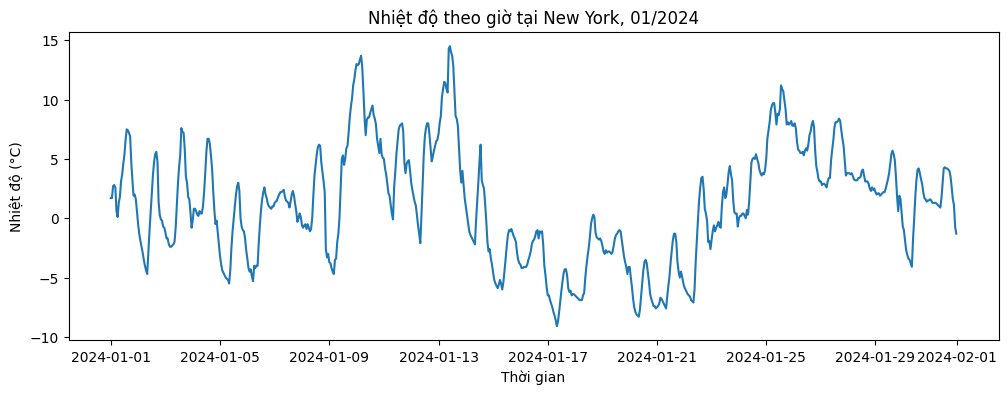

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(df["datetime"], df["temperature"])
plt.title("Nhiệt độ theo giờ tại New York, 01/2024")
plt.xlabel("Thời gian")
plt.ylabel("Nhiệt độ (°C)")
plt.show()


In [10]:
series = df["temperature"].fillna(method="ffill").values
print(f"Số lượng điểm dữ liệu: {len(series)}")


Số lượng điểm dữ liệu: 744


<ipython-input-10-a0059e38d90a>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = df["temperature"].fillna(method="ffill").values


In [11]:
import numpy as np

temp = series
window_sizes = [6, 24, 48]  # 6h, 24h, 48h
features = []
for w in window_sizes:
    rollmean = pd.Series(temp).rolling(window=w, min_periods=1).mean().values
    rolldiff = pd.Series(temp).diff(w).fillna(0).values
    rollstd = pd.Series(temp).rolling(window=w, min_periods=1).std().fillna(0).values
    features.append(rollmean)
    features.append(rolldiff)
    features.append(rollstd)
features = np.stack(features, axis=1)  # shape: (n_points, n_features)
print(features.shape)


(744, 9)


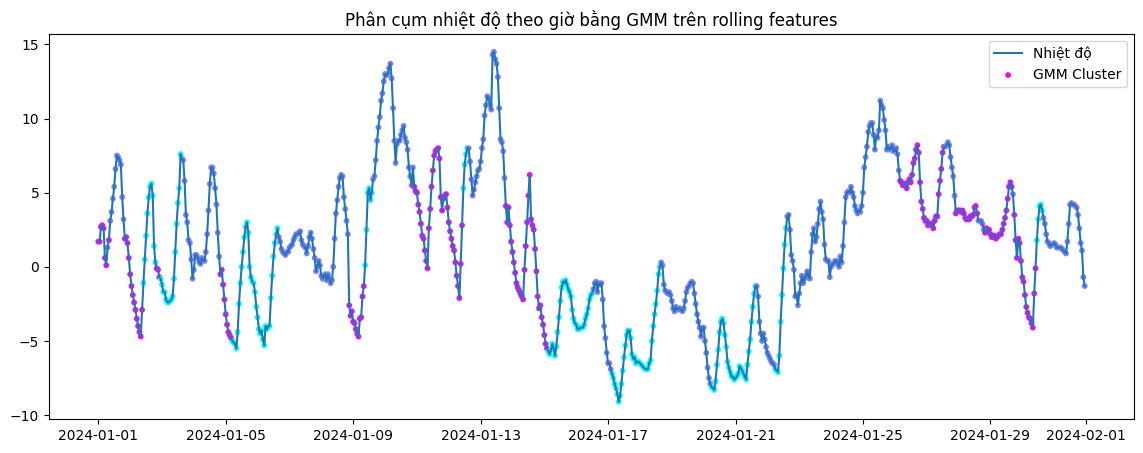

In [12]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(features)
labels = gmm.predict(features)

plt.figure(figsize=(14, 5))
plt.plot(df["datetime"], temp, label="Nhiệt độ")
plt.scatter(df["datetime"], temp, c=labels, cmap="cool", s=10, label="GMM Cluster")
plt.title("Phân cụm nhiệt độ theo giờ bằng GMM trên rolling features")
plt.legend()
plt.show()


In [17]:
import torch
import torch.nn as nn

class SimpleAutoformer(nn.Module):
    def __init__(self, input_len, pred_len, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.input_proj = nn.Linear(1, d_model)
        self.output_proj = nn.Linear(d_model, 1)
        self.input_len = input_len
        self.pred_len = pred_len

    def forward(self, src):
        src_emb = self.input_proj(src)
        memory = self.encoder(src_emb)
        out = self.output_proj(memory)
        return out, memory

# Chuẩn bị sliding window
input_len = 48  # 2 ngày
windows = []
for i in range(len(temp)-input_len):
    windows.append(temp[i:i+input_len])
X_windows = torch.tensor(windows, dtype=torch.float32).unsqueeze(-1)

# Lấy embedding
model = SimpleAutoformer(input_len=input_len, pred_len=1)
with torch.no_grad():
    outs, hiddens = model(X_windows)
    embedding = hiddens.mean(dim=1).numpy()  # (num_samples, d_model)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


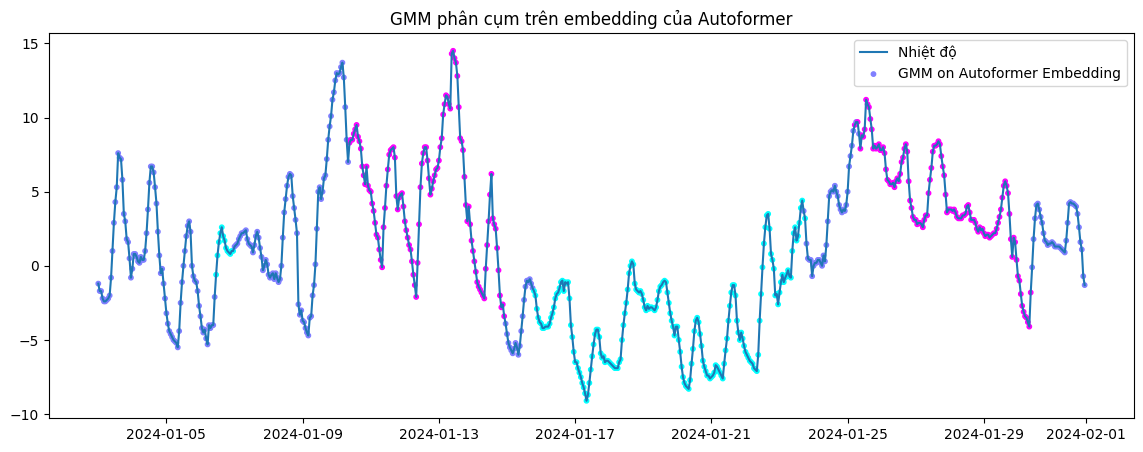

In [18]:
gmm2 = GaussianMixture(n_components=3, random_state=0)
gmm2.fit(embedding)
labels2 = gmm2.predict(embedding)

time_trimmed = df["datetime"].values[input_len:]
plt.figure(figsize=(14,5))
plt.plot(time_trimmed, temp[input_len:], label='Nhiệt độ')
plt.scatter(time_trimmed, temp[input_len:], c=labels2, cmap='cool', s=10, label='GMM on Autoformer Embedding')
plt.title('GMM phân cụm trên embedding của Autoformer')
plt.legend()
plt.show()
